In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

### Imports

In [2]:
import numpy as np
import os
import copy

import Src.YamlUtils as yu
import Src.DicData as dade
import Src.Slideshow as slide
import Src.KerasSequence as ks
import Src.ImgProcessing as img_proc
import Src.OversampleStreamData as osa
import Src.Speed as speed
import Src.Models as models
import Src.KerasCallbacks as kc

Using TensorFlow backend.


In [3]:
img_path = "Z:/ForschB/NeuroRace-Sim/forschB_data/{}/depth_camera/rgb/image_raw/compressed"
train_path = "Z:/ForschB/NeuroRace-Sim/forschB_data"

valid_img_path = "Z:/ForschB/NeuroRace-Sim/forschB_data_counter/{}/depth_camera/rgb/image_raw/compressed"
valid_path = "Z:/ForschB/NeuroRace-Sim/forschB_data_counter"

dirs = os.listdir(train_path)
valid_dirs = os.listdir(valid_path)

yamls = []
valid_yamls = []

for d in dirs:
    yamls.append("{}/{}/{}.yaml".format(train_path, d, d))
    
for d in valid_dirs:
    valid_yamls.append("{}/{}/{}.yaml".format(valid_path, d, d))

In [4]:
dicts = []
valid_dicts = []

for y in yamls:
    dicts.append(dade.convert_neuro_data_to_yaml(y))
    
for y in valid_yamls:
    valid_dicts.append(dade.convert_neuro_data_to_yaml(y))

In [5]:
def do_all(dic):
    dade.remove_data_with_speed_lower_than_threshold(dic)
    max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(dic)
    
    dade.add_speed_classes_to_dic(dic, threshold=0.05)
    
    # dade.normalize_dic_steering(dic, max_abs_steer)
    dade.normalize_dic_speed(dic, max_abs_speed)
    dade.add_steer_classes_to_dic(dic)
    dade.add_speed_cost_weight_to_dic(dic)
    dade.add_steer_cost_weight_to_dic(dic)
    
    return max_abs_steer, max_abs_speed

In [6]:
max_steers = []
max_speeds = []

for d in dicts:
    max_steer, max_speed = do_all(d)
    max_steers.append(max_steer)
    max_speeds.append(max_speed)
    
for d in valid_dicts:
    _, _ = do_all(d)

In [7]:
def combine_dicts(dict_list, dir_list, img_path):
    
    combined_dicts = {}
    
    k = 0
    
    for _dict, _dir in zip(dict_list, dir_list):
        
        for key in _dict.keys():
            
            combined_dicts[k] = copy.deepcopy(_dict[key])
            
            img_name = key
            
            if "img_name" in _dict[key].keys():
                img_name = _dict[key]["img_name"]
            
            combined_dicts[k]["img_name"] = key
            combined_dicts[k]["img_path"] = img_path.format(_dir)
            k += 1
            
    return combined_dicts

In [8]:
combined_dicts = combine_dicts(dicts, dirs, img_path)

In [9]:
combined_valid_dicts = combine_dicts(valid_dicts, valid_dirs, valid_img_path)

# Slideshow

In [10]:
i = 0

slide.slideshow(combined_dicts, 
                "", 
                minimal_steer=-1.0, maximal_steer=1.0,
                minimal_speed=0.0, maximal_speed=1.0,
                hz=100, img_file_type="jpg")

# Analyze

distribution in dict 

0: 397
1: 659
2: 1419
3: 3209
4: 5968
5: 27120
6: 33095
7: 9672
8: 2120
9: 1383
10: 727
11: 412
12: 287


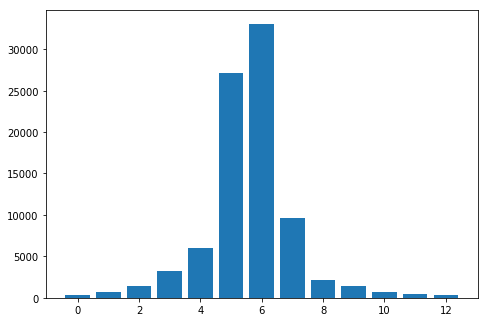

distribution in dict 

0: 68
1: 39
2: 203
3: 508
4: 821
5: 3133
6: 12607
7: 7772
8: 1734
9: 793
10: 338
11: 159
12: 80


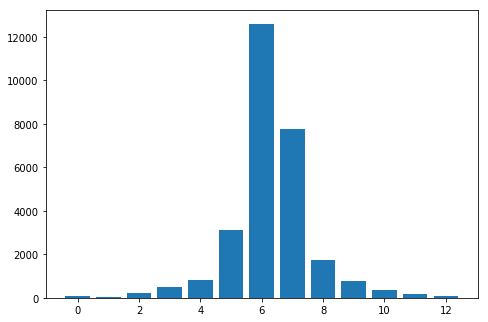

In [11]:
_ = osa.analyze_class_in_dic(combined_dicts, "steering_class")
_ = osa.analyze_class_in_dic(combined_valid_dicts, "steering_class")

# Oversampling

In [12]:
# oversampled_dicts = []

# class_key = "steering_class"

# for dic in dicts:
#     analyzed_key_lists = osa.analyze_class_in_dic(dic, class_key, verbose=0)
#     od = osa.oversample_class_in_dic(dic, analyzed_key_lists, class_key, verbose=0)
    
#     oversampled_dicts.append(od)

distribution after oversampling 

0: 3970
1: 6590
2: 14190
3: 32090
4: 29840
5: 27120
6: 33095
7: 29016
8: 21200
9: 13830
10: 7270
11: 4120
12: 2870


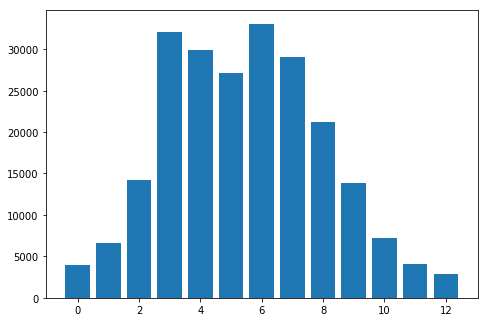

distribution after oversampling 

0: 680
1: 390
2: 2030
3: 5080
4: 8210
5: 12532
6: 12607
7: 7772
8: 12138
9: 7930
10: 3380
11: 1590
12: 800


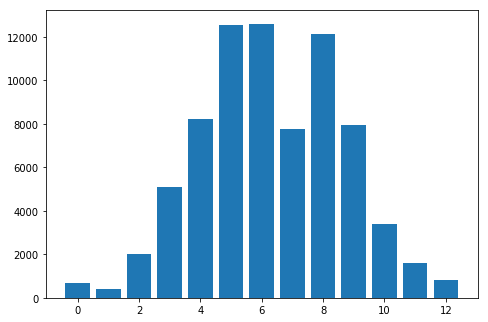

In [32]:
class_key = "steering_class"

analyzed_key_lists = osa.analyze_class_in_dic(combined_dicts, class_key, verbose=0)
oversampled_combined_dicts = osa.oversample_class_in_dic(combined_dicts, analyzed_key_lists, class_key, verbose=1)

analyzed_key_lists = osa.analyze_class_in_dic(combined_valid_dicts, class_key, verbose=0)
oversampled_combined_valid_dicts = osa.oversample_class_in_dic(combined_valid_dicts, analyzed_key_lists, class_key, verbose=1)

# Training

## Data gen

In [14]:
img_processor = img_proc.ImgProcessor()

img_processor.crop = True
img_processor.augment = False

img_processor.fx = 0.1
img_processor.fy = 0.2

In [15]:
batch_size = 1
sequence_size = 64

In [16]:
steer_gens = []

for f, d in zip(dicts, dirs):
    gen = ks.GeneratorSteer(f, img_path.format(d), img_processor, batch_size=256, img_file_type="jpg")
    gen.return_weights = False
    
    steer_gens.append(gen)
    

In [34]:
steer_valid_gens = []

for f, d in zip(valid_dicts, valid_dirs):
    gen = ks.GeneratorSteer(f, valid_img_path.format(d), img_processor, batch_size=256, img_file_type="jpg")
    gen.return_weights = False
    
    steer_valid_gens.append(gen)

In [33]:
# oversampled_gens = []

# for dic, di in zip(oversampled_dicts, dirs):

#     oversampled_gen = ks.GeneratorSteer(dic, img_path.format(di), img_processor, batch_size=256, img_file_type="jpg")
#     oversampled_gen.return_weights = False
    
#     oversampled_gens.append(oversampled_gen)

combined_gen = ks.GeneratorSteer(combined_dicts, "", img_processor, batch_size=256, img_file_type="jpg")
combined_gen.return_weights = False

combined_valid_gen = ks.GeneratorSteer(combined_valid_dicts, "", img_processor, batch_size=256, img_file_type="jpg")
combined_valid_gen.return_weights = False

oversampled_combined_gen = ks.GeneratorSteer(oversampled_combined_dicts, "", img_processor, batch_size=256, img_file_type="jpg")
oversampled_combined_gen.return_weights = False

oversampled_combined_valid_gen = ks.GeneratorSteer(oversampled_combined_valid_dicts, "", img_processor, batch_size=256, img_file_type="jpg")
oversampled_combined_valid_gen.return_weights = False

In [18]:
(imgs, _, ) = oversampled_combined_gen[0]
img_shape = imgs[0].shape
print(img_shape)

(64, 64, 3)


## Model

In [38]:
models.reset_session()

In [39]:
model = models.fabian_ket_cnn_research_b_steer_paper(img_shape, batch_size, compile_model=True, 
                                                     optimizer="adam", bias=True)

# reset_states_callback = kc.KerasRestStatesCallback(model)

In [40]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       (None, 64, 64, 3)         0         
_________________________________________________________________
conv01 (Conv2D)              (None, 64, 64, 96)        34944     
_________________________________________________________________
pool01 (MaxPooling2D)        (None, 32, 32, 96)        0         
_________________________________________________________________
conv_batch_norm01 (BatchNorm (None, 32, 32, 96)        384       
_________________________________________________________________
conv_relu01 (Activation)     (None, 32, 32, 96)        0         
_________________________________________________________________
conv02 (Conv2D)              (None, 32, 32, 256)       614656    
_________________________________________________________________
pool02 (MaxPooling2D)        (None, 16, 16, 256)       0         
__________

In [41]:
model_save_file = "steer_model_weights_64x64_sim_cnn_steer_paper()_adam_bias.h5"

In [23]:
model.load_weights( model_save_file )

In [47]:
history = model.fit_generator(
    generator=oversampled_combined_gen,
    steps_per_epoch=len(oversampled_combined_gen),
    # validation_data=oversampled_combined_valid_gen,
    # validation_steps=len(oversampled_combined_valid_gen),
    epochs=3,
    verbose=1,
    workers=1,
    use_multiprocessing=False,
    shuffle=True)
    # callbacks=[reset_states_callback])

Epoch 1/3
880/880 [==============================] - 727s 826ms/step - loss: 0.1433 - mean_absolute_error: 0.1433
Epoch 2/3
880/880 [==============================] - 698s 793ms/step - loss: 0.1383 - mean_absolute_error: 0.1383
Epoch 3/3
880/880 [==============================] - 703s 799ms/step - loss: 0.1346 - mean_absolute_error: 0.1346


In [49]:
model.save_weights( model_save_file )

In [35]:
import numpy as np
import cv2
import keras.backend as K
import copy
import time
import os

# own imports
import Src.Models as models
import Src.GenIterator as it

def get_mask_neg_batch_uses_mat(width, height, mask_width=1, mask_height=1):
    
    mask_batch = []
    neg_mask_batch = []
    
    uses = np.zeros((height, width, 1))
    mask = np.ones_like(uses)
    
    for y in range(height - mask_height + 1):
        for x in range(width - mask_width + 1):
                        
            mask[:, :, :] = 1
            mask[(0+y) : (mask_height+y), (0+x) : (mask_width+x), :] = 0       
            mask_batch.append(copy.deepcopy(mask))
            
            neg_mask = (1 - mask)
            neg_mask_batch.append(neg_mask)
            
            uses += neg_mask
    
    mask_batch = np.asarray(mask_batch)
    neg_mask_batch = np.asarray(neg_mask_batch)
    
    return mask_batch, neg_mask_batch, uses
    

def normalize_img(img):
    max_value = np.max(img)
    min_value = np.min(img)

    img -=  min_value
    img /= (max_value - min_value)
        
def heatmap(model, gen, save_dir="test/"):
    
    # create save dir
    t0 = time.time()
    save_dir = save_dir + "{}/".format(t0)
    os.mkdir(save_dir)
    
    n_round = 0
    
    width  = 64
    height = 64
    depth  = 3
    
    
    mask_batch, neg_mask_batch, uses = get_mask_neg_batch_uses_mat(width, height)
    
    length = width * height
    
    print("Start heatmap gen ...")
    
    for img, label in gen:
                
        t0 = time.time()

        result = np.zeros_like(uses)
        
        img_batch = np.asarray([img])
        mask_img_batch = np.multiply(img_batch, mask_batch)
        
        t1 = time.time()
        
        print("start predictions ... ({}sec)".format(t1 - t0))
        
        # you could just predict with the whole batch at once,
        # but then the internal lstm states wouldn't be reseted by keras
        # so we have to do it by ourself
        predictions = model.predict(mask_img_batch)
        
        del mask_img_batch
        
        ground_truth = model.predict([ img_batch ])
        
        del img_batch
        
        print("... predictions done ({}sec)".format(time.time() - t1))
        
        results = []
        
        idx = np.argmax(label)
        
        for neg_mask, predictions in zip(neg_mask_batch, predictions):
            tmp = np.multiply( neg_mask, np.sum(np.abs(predictions - ground_truth)) )
            results.append(tmp)
            
        results = np.asarray(results)
        
        results = np.sum(results, axis=0)
        results /= uses
        
        normalize_img(results)
        
        results = cv2.resize(results, (320, 320))
        results = np.reshape(results, (320, 320, 1))
        
        to_save = np.zeros((320, 320 * 2, depth))
        to_save[:, 0:320, :] += results * 255
        to_save[:, 320: , :] += cv2.resize(img, (320, 320)) * 255
        
        cv2.imwrite("{}{}.png".format(save_dir, time.time()), to_save)
        
        print("Duration {}: {}sec".format(n_round, time.time() - t0))
        print("==================")
        
        n_round += 1
                
    

In [36]:
simple_iter = it.SimpleIterator(steer_valid_gens[0])

In [37]:
heatmap(model, simple_iter)

Start heatmap gen ...
start predictions ... (0.3709604740142822sec)
... predictions done (2.2770957946777344sec)
Duration 0: 2.929488182067871sec
start predictions ... (0.36168622970581055sec)
... predictions done (1.6442489624023438sec)
Duration 1: 2.265287399291992sec
start predictions ... (0.35376620292663574sec)
... predictions done (1.6379237174987793sec)
Duration 2: 2.289358615875244sec
start predictions ... (0.36229896545410156sec)
... predictions done (1.6364936828613281sec)
Duration 3: 2.242999315261841sec
start predictions ... (0.3537018299102783sec)
... predictions done (1.622330665588379sec)
Duration 4: 2.249091386795044sec
start predictions ... (0.377899169921875sec)
... predictions done (1.588630199432373sec)
Duration 5: 2.220449209213257sec
start predictions ... (0.3785085678100586sec)
... predictions done (1.7266926765441895sec)
Duration 6: 2.3903818130493164sec
start predictions ... (0.3433799743652344sec)
... predictions done (1.6792800426483154sec)
Duration 7: 2.2765

Duration 56: 2.192399501800537sec
start predictions ... (0.3459463119506836sec)
... predictions done (1.610400676727295sec)
Duration 57: 2.180891275405884sec
start predictions ... (0.3718893527984619sec)
... predictions done (1.5845491886138916sec)
Duration 58: 2.2103846073150635sec
start predictions ... (0.35804009437561035sec)
... predictions done (1.6179301738739014sec)
Duration 59: 2.1729788780212402sec
start predictions ... (0.3616976737976074sec)
... predictions done (1.5975031852722168sec)
Duration 60: 2.194490671157837sec
start predictions ... (0.3617682456970215sec)
... predictions done (1.6223056316375732sec)
Duration 61: 2.1948816776275635sec
start predictions ... (0.36164259910583496sec)
... predictions done (1.5838730335235596sec)
Duration 62: 2.224186658859253sec
start predictions ... (0.3665590286254883sec)
... predictions done (1.619544506072998sec)
Duration 63: 2.18196702003479sec
start predictions ... (0.35970401763916016sec)
... predictions done (1.554901123046875sec

... predictions done (1.615797758102417sec)
Duration 113: 2.1766605377197266sec
start predictions ... (0.3817627429962158sec)
... predictions done (1.6103897094726562sec)
Duration 114: 2.217135190963745sec
start predictions ... (0.37163257598876953sec)
... predictions done (1.5841803550720215sec)
Duration 115: 2.176270008087158sec
start predictions ... (0.361644983291626sec)
... predictions done (1.5911505222320557sec)
Duration 116: 2.1989071369171143sec
start predictions ... (0.36196470260620117sec)
... predictions done (1.5930132865905762sec)
Duration 117: 2.1645052433013916sec
start predictions ... (0.36371874809265137sec)
... predictions done (1.5902338027954102sec)
Duration 118: 2.1788578033447266sec
start predictions ... (0.3841516971588135sec)
... predictions done (1.6019246578216553sec)
Duration 119: 2.1866209506988525sec
start predictions ... (0.3789801597595215sec)
... predictions done (1.6042766571044922sec)
Duration 120: 2.2060296535491943sec
start predictions ... (0.353450

Duration 169: 2.2323787212371826sec
start predictions ... (0.36783456802368164sec)
... predictions done (1.6536035537719727sec)
Duration 170: 2.2631020545959473sec
start predictions ... (0.40194034576416016sec)
... predictions done (1.6892621517181396sec)
Duration 171: 2.297105073928833sec
start predictions ... (0.3618285655975342sec)
... predictions done (1.593484878540039sec)
Duration 172: 2.187185525894165sec
start predictions ... (0.36176562309265137sec)
... predictions done (1.5718653202056885sec)
Duration 173: 2.1810555458068848sec
start predictions ... (0.3567647933959961sec)
... predictions done (1.7483108043670654sec)
Duration 174: 2.3503952026367188sec
start predictions ... (0.3799924850463867sec)
... predictions done (1.794079065322876sec)
Duration 175: 2.394782304763794sec
start predictions ... (0.3722414970397949sec)
... predictions done (1.7590429782867432sec)
Duration 176: 2.3660809993743896sec
start predictions ... (0.35489964485168457sec)
... predictions done (1.796859

start predictions ... (0.3655545711517334sec)
... predictions done (1.6354691982269287sec)
Duration 226: 2.230224132537842sec
start predictions ... (0.38191747665405273sec)
... predictions done (1.5903069972991943sec)
Duration 227: 2.206998825073242sec
start predictions ... (0.36156487464904785sec)
... predictions done (1.5845577716827393sec)
Duration 228: 2.1618571281433105sec
start predictions ... (0.37376880645751953sec)
... predictions done (1.5999259948730469sec)
Duration 229: 2.190979242324829sec
start predictions ... (0.36987996101379395sec)
... predictions done (1.611119270324707sec)
Duration 230: 2.1949329376220703sec
start predictions ... (0.36176276206970215sec)
... predictions done (1.599748134613037sec)
Duration 231: 2.2154440879821777sec
start predictions ... (0.3702661991119385sec)
... predictions done (1.6022286415100098sec)
Duration 232: 2.1873576641082764sec
start predictions ... (0.36184048652648926sec)
... predictions done (1.6041712760925293sec)
Duration 233: 2.224

... predictions done (1.6323864459991455sec)
Duration 282: 2.2170252799987793sec
start predictions ... (0.36176323890686035sec)
... predictions done (1.6833367347717285sec)
Duration 283: 2.295184373855591sec
start predictions ... (0.37378692626953125sec)
... predictions done (1.5890123844146729sec)
Duration 284: 2.1945862770080566sec
start predictions ... (0.36623048782348633sec)
... predictions done (1.5881330966949463sec)
Duration 285: 2.201289176940918sec
start predictions ... (0.39220643043518066sec)
... predictions done (1.6046416759490967sec)
Duration 286: 2.1973865032196045sec
start predictions ... (0.37092089653015137sec)
... predictions done (1.7538652420043945sec)
Duration 287: 2.372210741043091sec
start predictions ... (0.37107324600219727sec)
... predictions done (1.7720975875854492sec)
Duration 288: 2.359342098236084sec
start predictions ... (0.3825826644897461sec)
... predictions done (1.7226378917694092sec)
Duration 289: 2.3680713176727295sec
start predictions ... (0.371

Duration 338: 2.2148172855377197sec
start predictions ... (0.3718109130859375sec)
... predictions done (1.6086704730987549sec)
Duration 339: 2.2500360012054443sec
start predictions ... (0.3576514720916748sec)
... predictions done (1.6583614349365234sec)
Duration 340: 2.2433505058288574sec
start predictions ... (0.3617522716522217sec)
... predictions done (1.5945804119110107sec)
Duration 341: 2.186893939971924sec
start predictions ... (0.35979723930358887sec)
... predictions done (1.6268386840820312sec)
Duration 342: 2.184920072555542sec
start predictions ... (0.3540832996368408sec)
... predictions done (1.5979020595550537sec)
Duration 343: 2.1873860359191895sec
start predictions ... (0.3638343811035156sec)
... predictions done (1.6531765460968018sec)
Duration 344: 2.2184929847717285sec
start predictions ... (0.3917222023010254sec)
... predictions done (1.5845751762390137sec)
Duration 345: 2.230225086212158sec
start predictions ... (0.3577108383178711sec)
... predictions done (1.6644427

start predictions ... (0.37170863151550293sec)
... predictions done (1.6526515483856201sec)
Duration 395: 2.2405261993408203sec
start predictions ... (0.3413252830505371sec)
... predictions done (1.714231014251709sec)
Duration 396: 2.286029100418091sec
start predictions ... (0.3819551467895508sec)
... predictions done (1.677457571029663sec)
Duration 397: 2.266664505004883sec
start predictions ... (0.402329683303833sec)
... predictions done (1.6418895721435547sec)
Duration 398: 2.277129888534546sec
start predictions ... (0.3817002773284912sec)
... predictions done (1.7148592472076416sec)
Duration 399: 2.313854217529297sec
start predictions ... (0.3623838424682617sec)
... predictions done (1.6811652183532715sec)
Duration 400: 2.287601947784424sec
start predictions ... (0.37198305130004883sec)
... predictions done (1.6275739669799805sec)
Duration 401: 2.2089154720306396sec
start predictions ... (0.37285447120666504sec)
... predictions done (1.6412181854248047sec)
Duration 402: 2.286253929

KeyboardInterrupt: 